In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
import re

# Loading the given card_transaction dataset using panda

input_data = pd.read_csv("/home/cselab/Desktop/fraud_analytics/card_transaction.v1.csv")

# Removing '$' from 'Amount' column using regex and converting it to float datatype to align data in same format
input_data['Amount'] = input_data['Amount'].replace('[\$,]', '', regex=True).astype(float)

# Encodes categorical columns in the DataFrame input_data using LabelEncoder and stores the encoder instances in a dictionary
# We used LabelEncoder is  to transform categorical text data into numerical data.

encoder_dict = {}
categorical_columns = ['Use Chip', 'Merchant City', 'Merchant State', 'Errors?', 'Is Fraud?']
for column in categorical_columns:
    label_encoder = LabelEncoder()
    input_data[column] = label_encoder.fit_transform(input_data[column].astype(str))
    encoder_dict[column] = label_encoder

#  'Time' column has data in HH:MM format so to align data in the same format for making processing easier, splitting Time into Hours and Minutes and dropped 'Time' from input_data 
time_values = input_data['Time'].str.split(':')
input_data['Hour'] = [int(x[0]) if len(x) >= 2 else np.nan for x in time_values]
input_data['Minute'] = [int(x[1]) if len(x) >= 2 else np.nan for x in time_values]
input_data.drop('Time', axis=1, inplace=True)

# Handle missing values and filled missing values with column mean
input_data.fillna(input_data.mean(), inplace=True) 

# Separate features and target
X = input_data.drop('Amount', axis=1)
y = input_data['Amount']

# Scale numeric features and used MinMaxScaler  for scaling features to a range, typically between 0 and 1.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Defined custom loss function for VAE
class CustomVariationalLayer(Layer):
    def vae_loss(self, x, x_decoded_mean, z_log_var, z_mean):
        xent_loss = K.mean(K.square(x - x_decoded_mean), axis=-1)
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        z_log_var = inputs[2]
        z_mean = inputs[3]
        loss = self.vae_loss(x, x_decoded_mean, z_log_var, z_mean)
        self.add_loss(loss)
        return x

# Defined VAE architecture
latent_dim = 2  # Latent dimension

# Encoder parameters
inputs = Input(shape=(X_scaled.shape[1],))
h = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampling function 
# This function generates samples from the latent space distribution using the reparameterization trick, which enables gradient-based optimization of the VAE during training
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Reparameterization trick
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder parameters
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(X_scaled.shape[1])

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Instantiate VAE model
y = CustomVariationalLayer()([inputs, x_decoded_mean, z_log_var, z_mean])
vae = Model(inputs, y)

# Compile VAE model using mse as loss and adam as optimizer 
vae.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using scaled input data with epoch 10 and batch size 128
vae.fit(X_scaled, X_scaled, epochs=10, batch_size=128)


/tmp/ipykernel_430975/3136228259.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-27 17:07:32.858398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 17:07:32.885549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

Epoch 1/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 16s 784us/step - loss: 0.0649
Epoch 2/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 15s 746us/step - loss: 0.0614
Epoch 3/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 16s 787us/step - loss: 0.0614
Epoch 4/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 14s 701us/step - loss: 0.0614
Epoch 5/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 14s 687us/step - loss: 0.0614
Epoch 6/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 17s 839us/step - loss: 0.0614
Epoch 7/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 15s 765us/step - loss: 0.0614
Epoch 8/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 15s 750us/step - loss: 0.0614
Epoch 9/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 15s 727us/step - loss: 0.0614
Epoch 10/10
19963/19963 ━━━━━━━━━━━━━━━━━━━━ 15s 742us/step - loss: 0.0613


In [2]:
# Step 3: Generate Synthetic Data --- Generate 2 million transactions
# Define the number of transactions to generate

num_transactions = 2000000

# Generate synthetic data using the trained VAE model
generated_synthetic_data = vae.predict(X_scaled[:num_transactions])

# Print the number of generated transactions
print(len(generated_synthetic_data))

# Print the generated synthetic data
print(generated_synthetic_data)



62500/62500 ━━━━━━━━━━━━━━━━━━━━ 14s 226us/step
2000000
[[0.         0.         0.28       ... 0.         0.26086956 0.3559322 ]
 [0.         0.         0.28       ... 0.         0.26086956 0.7118644 ]
 [0.         0.         0.28       ... 0.         0.26086956 0.37288135]
 ...
 [0.75813955 0.125      0.68       ... 0.         0.6956522  0.        ]
 [0.75813955 0.125      0.68       ... 0.         0.7826087  0.03389831]
 [0.75813955 0.125      0.68       ... 0.         0.08695652 0.30508474]]


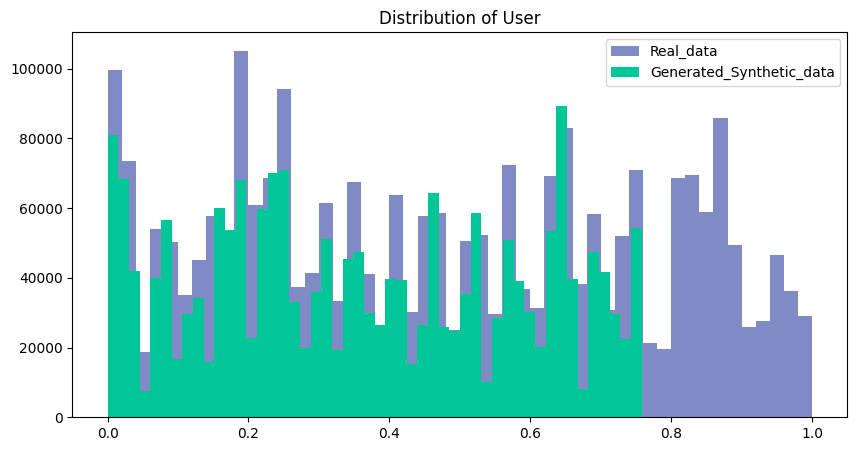

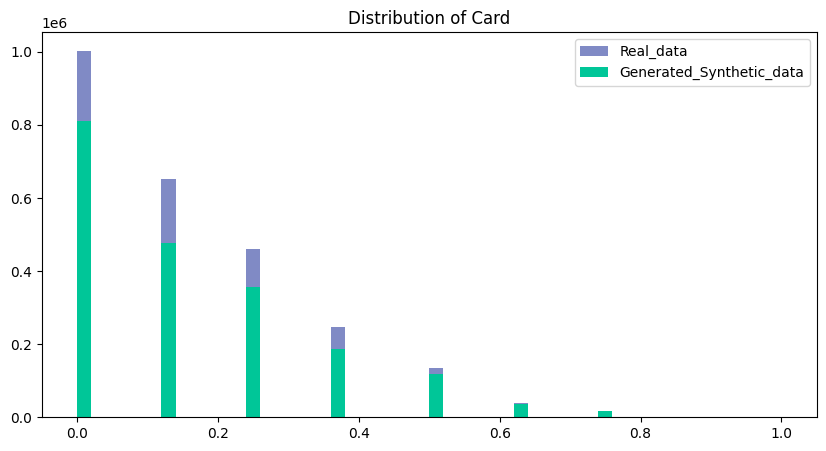

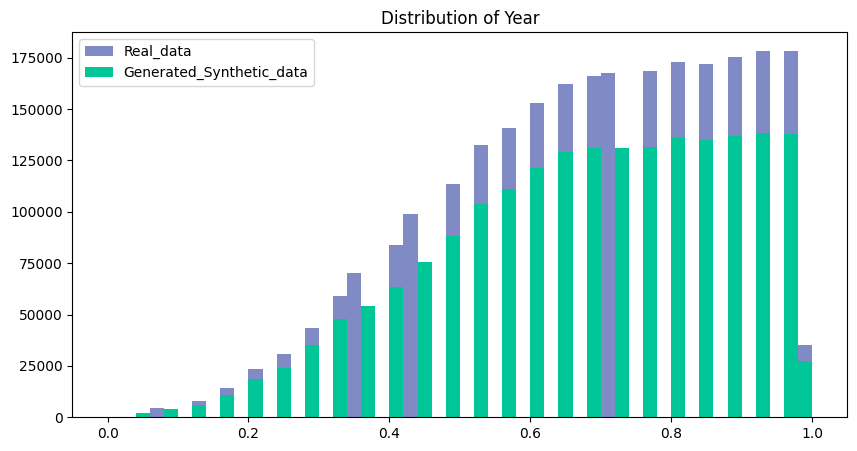

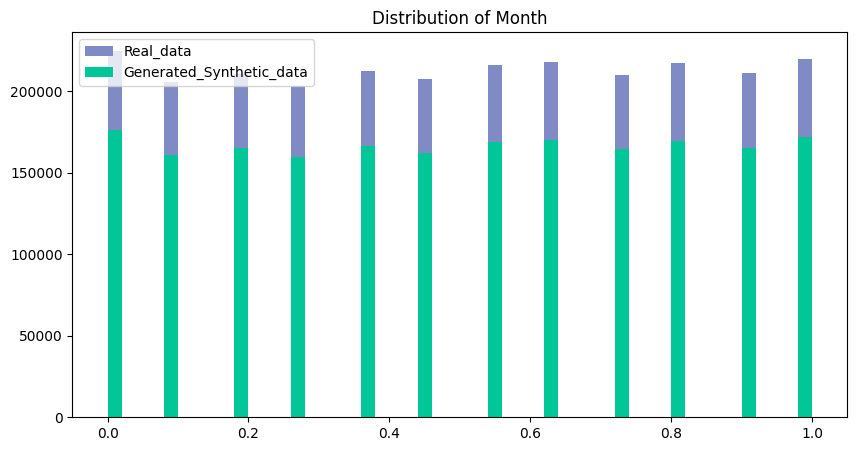

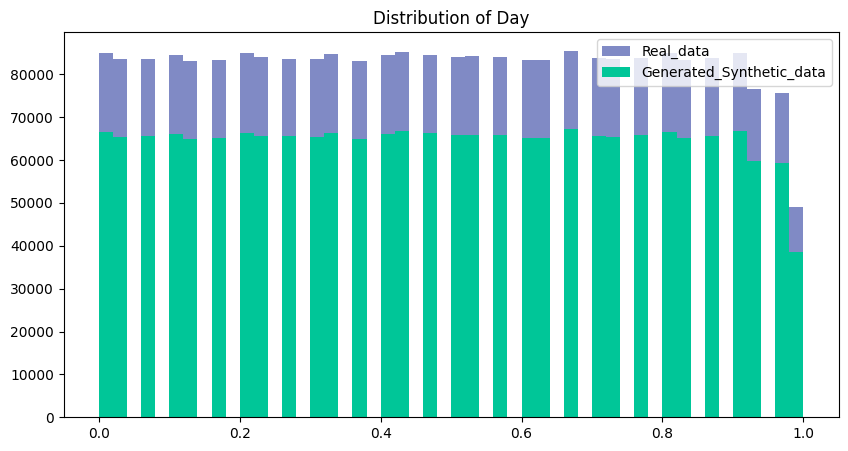

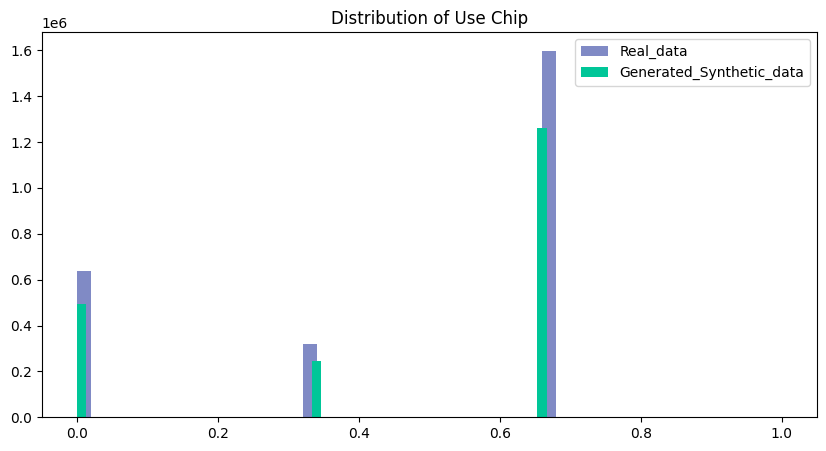

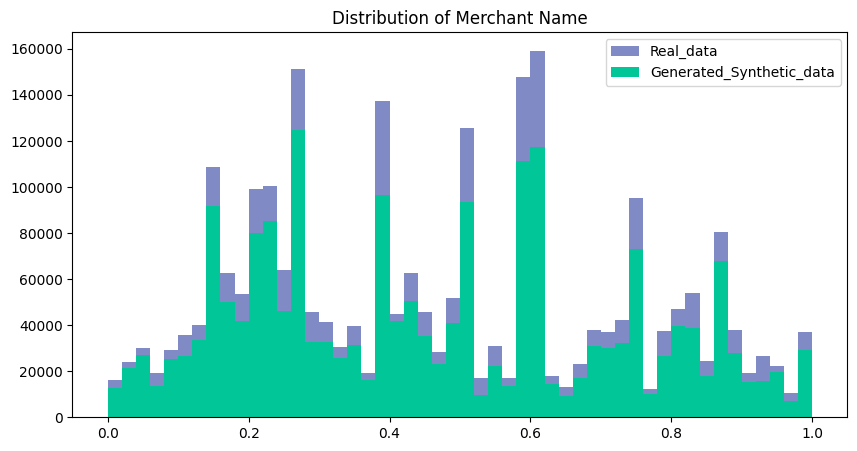

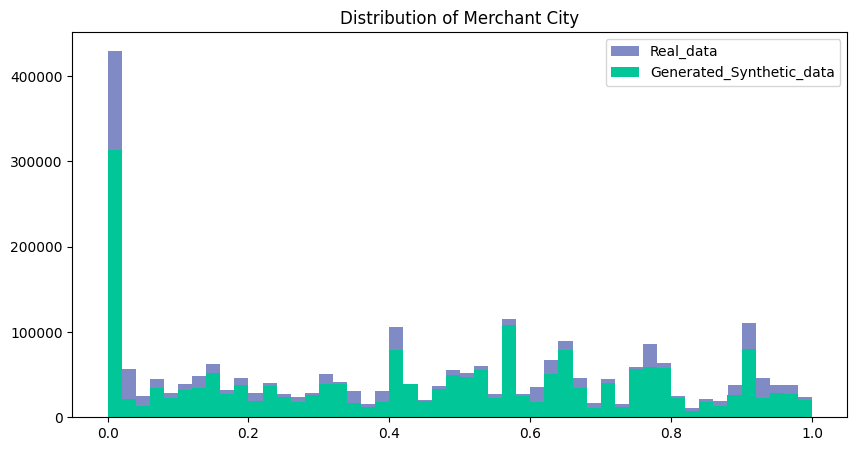

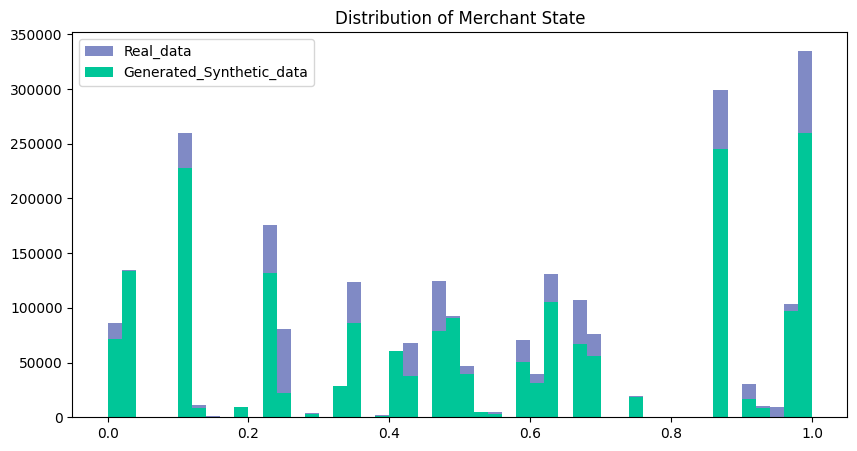

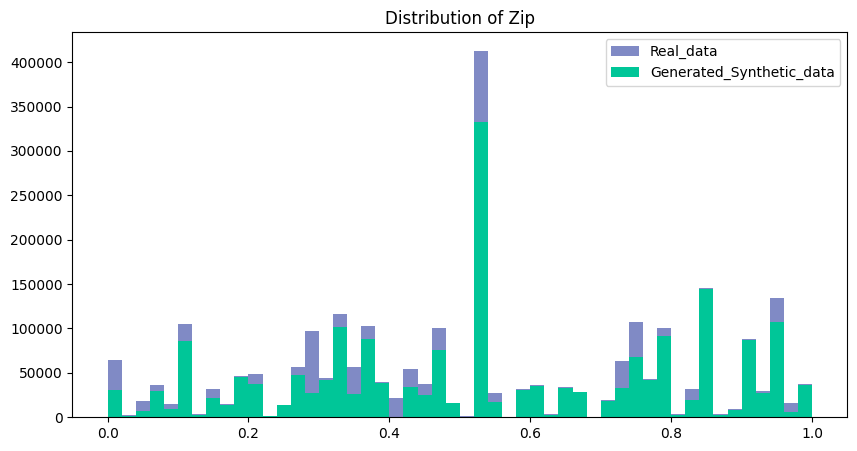

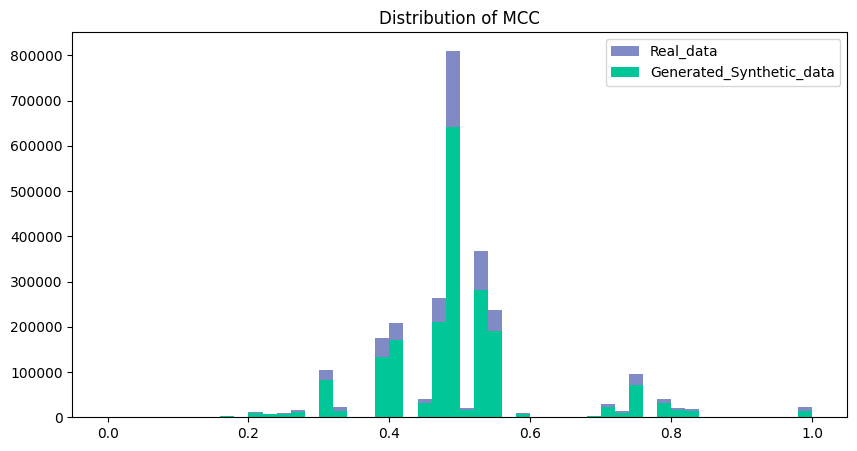

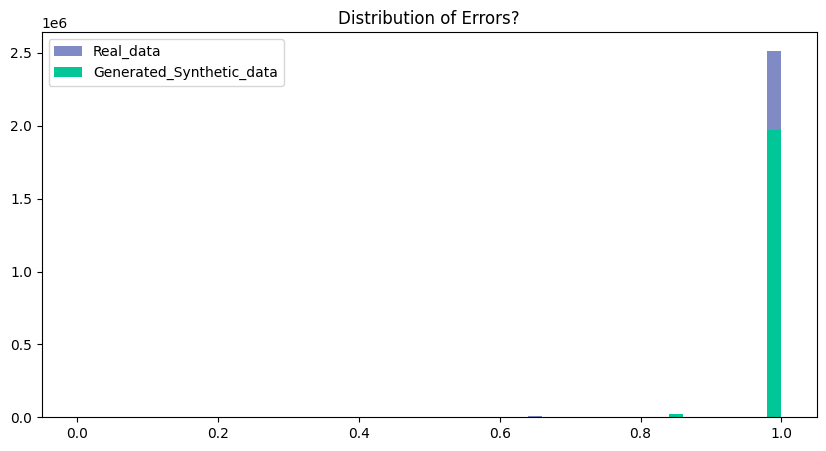

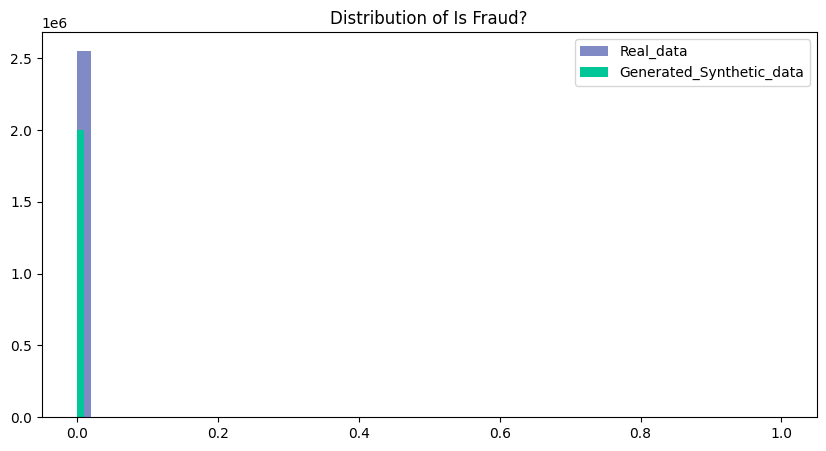

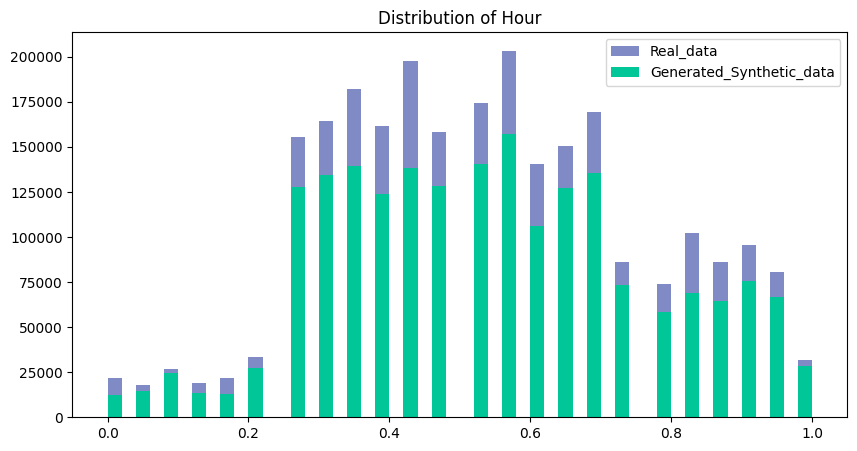

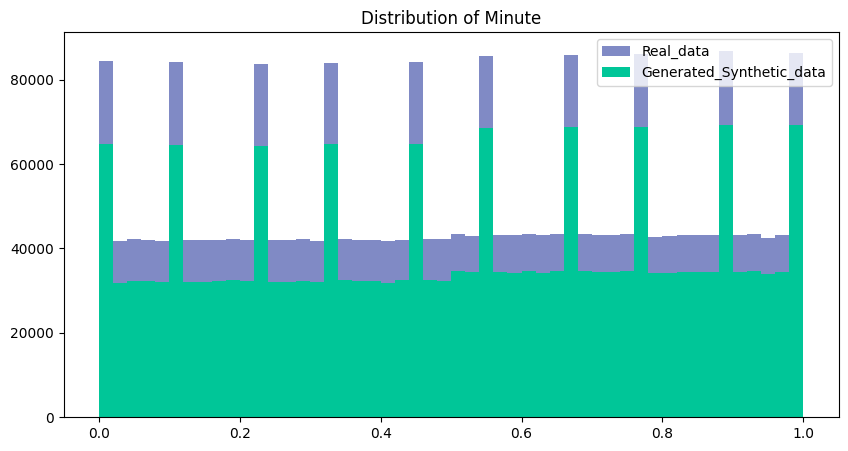

In [3]:
import matplotlib.pyplot as plt
# Plotting real vs generated synthetic data distribution
num_columns = X_scaled.shape[1]  # Get the number of columns
for i in range(num_columns):
    plt.figure(figsize=(10, 5))
    plt.hist(X_scaled[:, i], bins=50, alpha=1, color='#808ac5', label='Real_data')
    plt.hist(generated_synthetic_data[:, i], bins=50, alpha=1, color='#00c698', label='Generated_Synthetic_data')
    plt.title(f"Distribution of {X.columns[i]}")
    plt.legend()
    plt.show()


In [4]:
import numpy as np

# Concatenate X_scaled and synthetic_data along axis 0
total = np.concatenate((X_scaled, generated_synthetic_data), axis=0)

# Calculate duplicate records
dup_total = len(total) - len(np.unique(total, axis=0))
dup_real = len(X_scaled) - len(np.unique(X_scaled, axis=0))
dup_synthetic = len(generated_synthetic_data) - len(np.unique(generated_synthetic_data, axis=0))

# Calculate copies
Copies = dup_total - dup_real - dup_synthetic

# Update dup_total
dup_total = dup_real
len_syn=len(generated_synthetic_data)
len_syn_dropped=len(np.unique(generated_synthetic_data, axis=0))
# Print results
print("Copies:", Copies)
print("Duplicates in total:", dup_total)
print("Percentage of duplicate data  in synthetic data i.e self copy :", ((len_syn - len_syn_dropped) / len_syn) * 100)

#If `dup_total` is equal to `dup_real`, it indicates that there are no additional duplicates beyond what already existed in the real data. 
#This means that the synthetic data does not contain any direct copies of the real data. 
#Each synthetic record is unique and does not directly replicate any record from the real dataset. 
#Having zero copies in the synthetic data is generally a desirable outcome, as it suggests that the synthetic data generation process is creating diverse and novel samples that are not simply replicas of existing real data points. 
#It indicates that the synthetic data is effectively capturing the underlying patterns and distributions of the real data without introducing redundancy or overfitting issues. 
#Therefore, achieving zero copies is a positive result in most cases.

Copies: 0
Duplicates in total: 9871
Percentage of duplicate data  in synthetic data i.e self copy : 0.38895
